<a href="https://colab.research.google.com/github/koya75/Honda/blob/master/SpringSeminar_PyTorch1_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 春の勉強会 (PyTorch1)

## モジュールの呼び出し

In [1]:
import numpy as np
import argparse
import sys

import urllib
import zipfile
import os

import torch
import torch.nn as nn #計算グラフの構築に使用
import torch.optim as optim #最適化アルゴリズム
import torchsummary #特徴マップのサイズ確認
import torchvision #機械学習のフレームワーク
import torchvision.transforms as transform #画像変換
from torch.utils.data import DataLoader, Dataset #Detaloader
from torchvision.datasets import MNIST
from torch.autograd import Variable #自動で微分

## モデルクラスの定義

In [2]:
class NN(nn.Module):
    def __init__(self,in_size,hidden_size,out_size):
        super(NN,self).__init__()
        self.xh = nn.Linear(in_size,hidden_size) #全結合層
        #self.xh2 = nn.Linear(hidden_size,hidden_size)　課題1
        self.ho = nn.Linear(hidden_size,out_size) #全結合層
        self.act = nn.ReLU() #ReLU関数
        self.softmax = nn.Softmax(dim=1)
    def forward(self,x,train=False):
        x = x.view(-1,28*28) #28*28に調整
        h = self.act(self.xh(x))
        #h = self.act(self.xh2(h))　課題1
        y = self.act(self.ho(h))
        if train:
            return y
        return self.softmax(y)

## パラメータの設定

In [3]:
parser=argparse.ArgumentParser()
parser.add_argument('--epoch',type=int,default=20,help='number of epoch')
parser.add_argument('--in_size',type=int,default=784,help='input size')
parser.add_argument('--hidden_size',type=int,default=500,help='hidden size')
parser.add_argument('--out_size',type=int,default=10,help='output size')
parser.add_argument('--batch_size',type=int,default=32,help='number of batch size')
parser.add_argument('--lr',type=float,default=0.03,help='number of learning rate')
args=parser.parse_args(args=[])

## データセットのダウンロード

足立先輩のdropboxからMNISTをダウンロード


In [4]:
class MNIST_Loader(Dataset):
  def __init__(self, train=True, download=True, transform=None):
    self.transform = transform
    self.url = 'https://www.dropbox.com/s/hc7ukm7vzst5e40/MNIST.zip?dl=1'
    
    if download:
      self._download()
    
    dname = os.path.join(self.url.rpartition('/')[2][:-9], 'processed')
    if train:
      datapath = os.path.join(dname, 'training.pt')
    else:
      datapath = os.path.join(dname, 'test.pt')
  
    self.data = torch.load(datapath)

  def __len__(self):
    return len(self.data[0])

  def _download(self):
    filename = self.url.rpartition('/')[2][:-5]
    urllib.request.urlretrieve(self.url, filename)

    with zipfile.ZipFile(filename) as existing_zip:
      existing_zip.extractall()
    os.remove(filename)

  def __getitem__(self, i):
    image = transform.ToPILImage()(self.data[0][i])
    label = self.data[1][i]

    if self.transform:
      image = self.transform(image)
    return image, label

In [5]:
try:
  mnist_data = MNIST(root='./data', train=True, transform=transform.ToTensor(), download=True)
except: #例外処理
  print('Warning: Switch the original implementation because official MNIST data did not download (probably the official server has down).')
  mnist_data = MNIST_Loader(train=True, download=True, transform=transform.ToTensor())
print('Done!')

#data_loader = DataLoader(dataset=mnist_data, batch_size=args.batch_size, shuffle=True)

Done!


## 学習用データと評価用データを用意

In [6]:
#train_data=MNIST(dataset=mnist_data,train=True,download=False, transform=transform.ToTensor())
train_loader=DataLoader(mnist_data,batch_size=args.batch_size,shuffle=True)
#test_data=MNIST(dataset=mnist_data,train=False,download=True,transform=transform.ToTensor())
test_loader=DataLoader(mnist_data,batch_size=1,shuffle=True)

## モデルの読み込み

In [7]:
model=NN(args.in_size,args.hidden_size,args.out_size)

In [8]:
torchsummary.summary(model, (1,28,28)) #確認用

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 500]         392,500
              ReLU-2                  [-1, 500]               0
            Linear-3                   [-1, 10]           5,010
              ReLU-4                   [-1, 10]               0
           Softmax-5                   [-1, 10]               0
Total params: 397,510
Trainable params: 397,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.52
Estimated Total Size (MB): 1.53
----------------------------------------------------------------


## 損失関数と最適化手法の定義

In [9]:
criterion = nn.CrossEntropyLoss() #損失関数をCross Entropyに設定
optimizer = optim.SGD(model.parameters(),lr=args.lr) #SGDに設定
#optimizer = optim.Adam(model.parameters(),lr=args.lr)　課題2

## 学習&評価用コード

In [10]:
for epoch in range(args.epoch):
    run_loss=0
    correct=0
    total=0
    for i,data in enumerate(train_loader):
        inputs,labels=data
        inputs,labels=Variable(inputs),Variable(labels)
        optimizer.zero_grad()
        outputs=model(inputs,train=True)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        run_loss+=loss.item()
        if i==len(train_loader)-1:
            print('%d loss:%.7f'%(epoch+1,run_loss/len(train_loader)))
            run_loss=0
    for i,data in enumerate(test_loader):
        inputs,labels=data
        inputs,labels=Variable(inputs),Variable(labels)
        outputs=model(inputs,train=False)
        predicted=torch.argmax(outputs)
        total+=labels.size(0)
        correct+=(predicted==labels).sum()
    print("Accuracy %d /%d =%.5f" % (correct,total,float(correct)/total))
    print("========================")

1 loss:1.3768749
Accuracy 37803 /60000 =0.63005
2 loss:0.7370413
Accuracy 45450 /60000 =0.75750
3 loss:0.6593231
Accuracy 46001 /60000 =0.76668
4 loss:0.6254650
Accuracy 46384 /60000 =0.77307
5 loss:0.6018280
Accuracy 46644 /60000 =0.77740
6 loss:0.5838300
Accuracy 46902 /60000 =0.78170
7 loss:0.5693587
Accuracy 47009 /60000 =0.78348
8 loss:0.5579635
Accuracy 47215 /60000 =0.78692
9 loss:0.5487279
Accuracy 47305 /60000 =0.78842
10 loss:0.5404257
Accuracy 47379 /60000 =0.78965
11 loss:0.5338761
Accuracy 47461 /60000 =0.79102
12 loss:0.5276668
Accuracy 47547 /60000 =0.79245
13 loss:0.3719937
Accuracy 53013 /60000 =0.88355
14 loss:0.3099767
Accuracy 53169 /60000 =0.88615
15 loss:0.3018286
Accuracy 53256 /60000 =0.88760
16 loss:0.1404488
Accuracy 58861 /60000 =0.98102
17 loss:0.0742685
Accuracy 58963 /60000 =0.98272
18 loss:0.0673393
Accuracy 59095 /60000 =0.98492
19 loss:0.0613781
Accuracy 59157 /60000 =0.98595
20 loss:0.0566883
Accuracy 59259 /60000 =0.98765


## 分類された画像のプロット

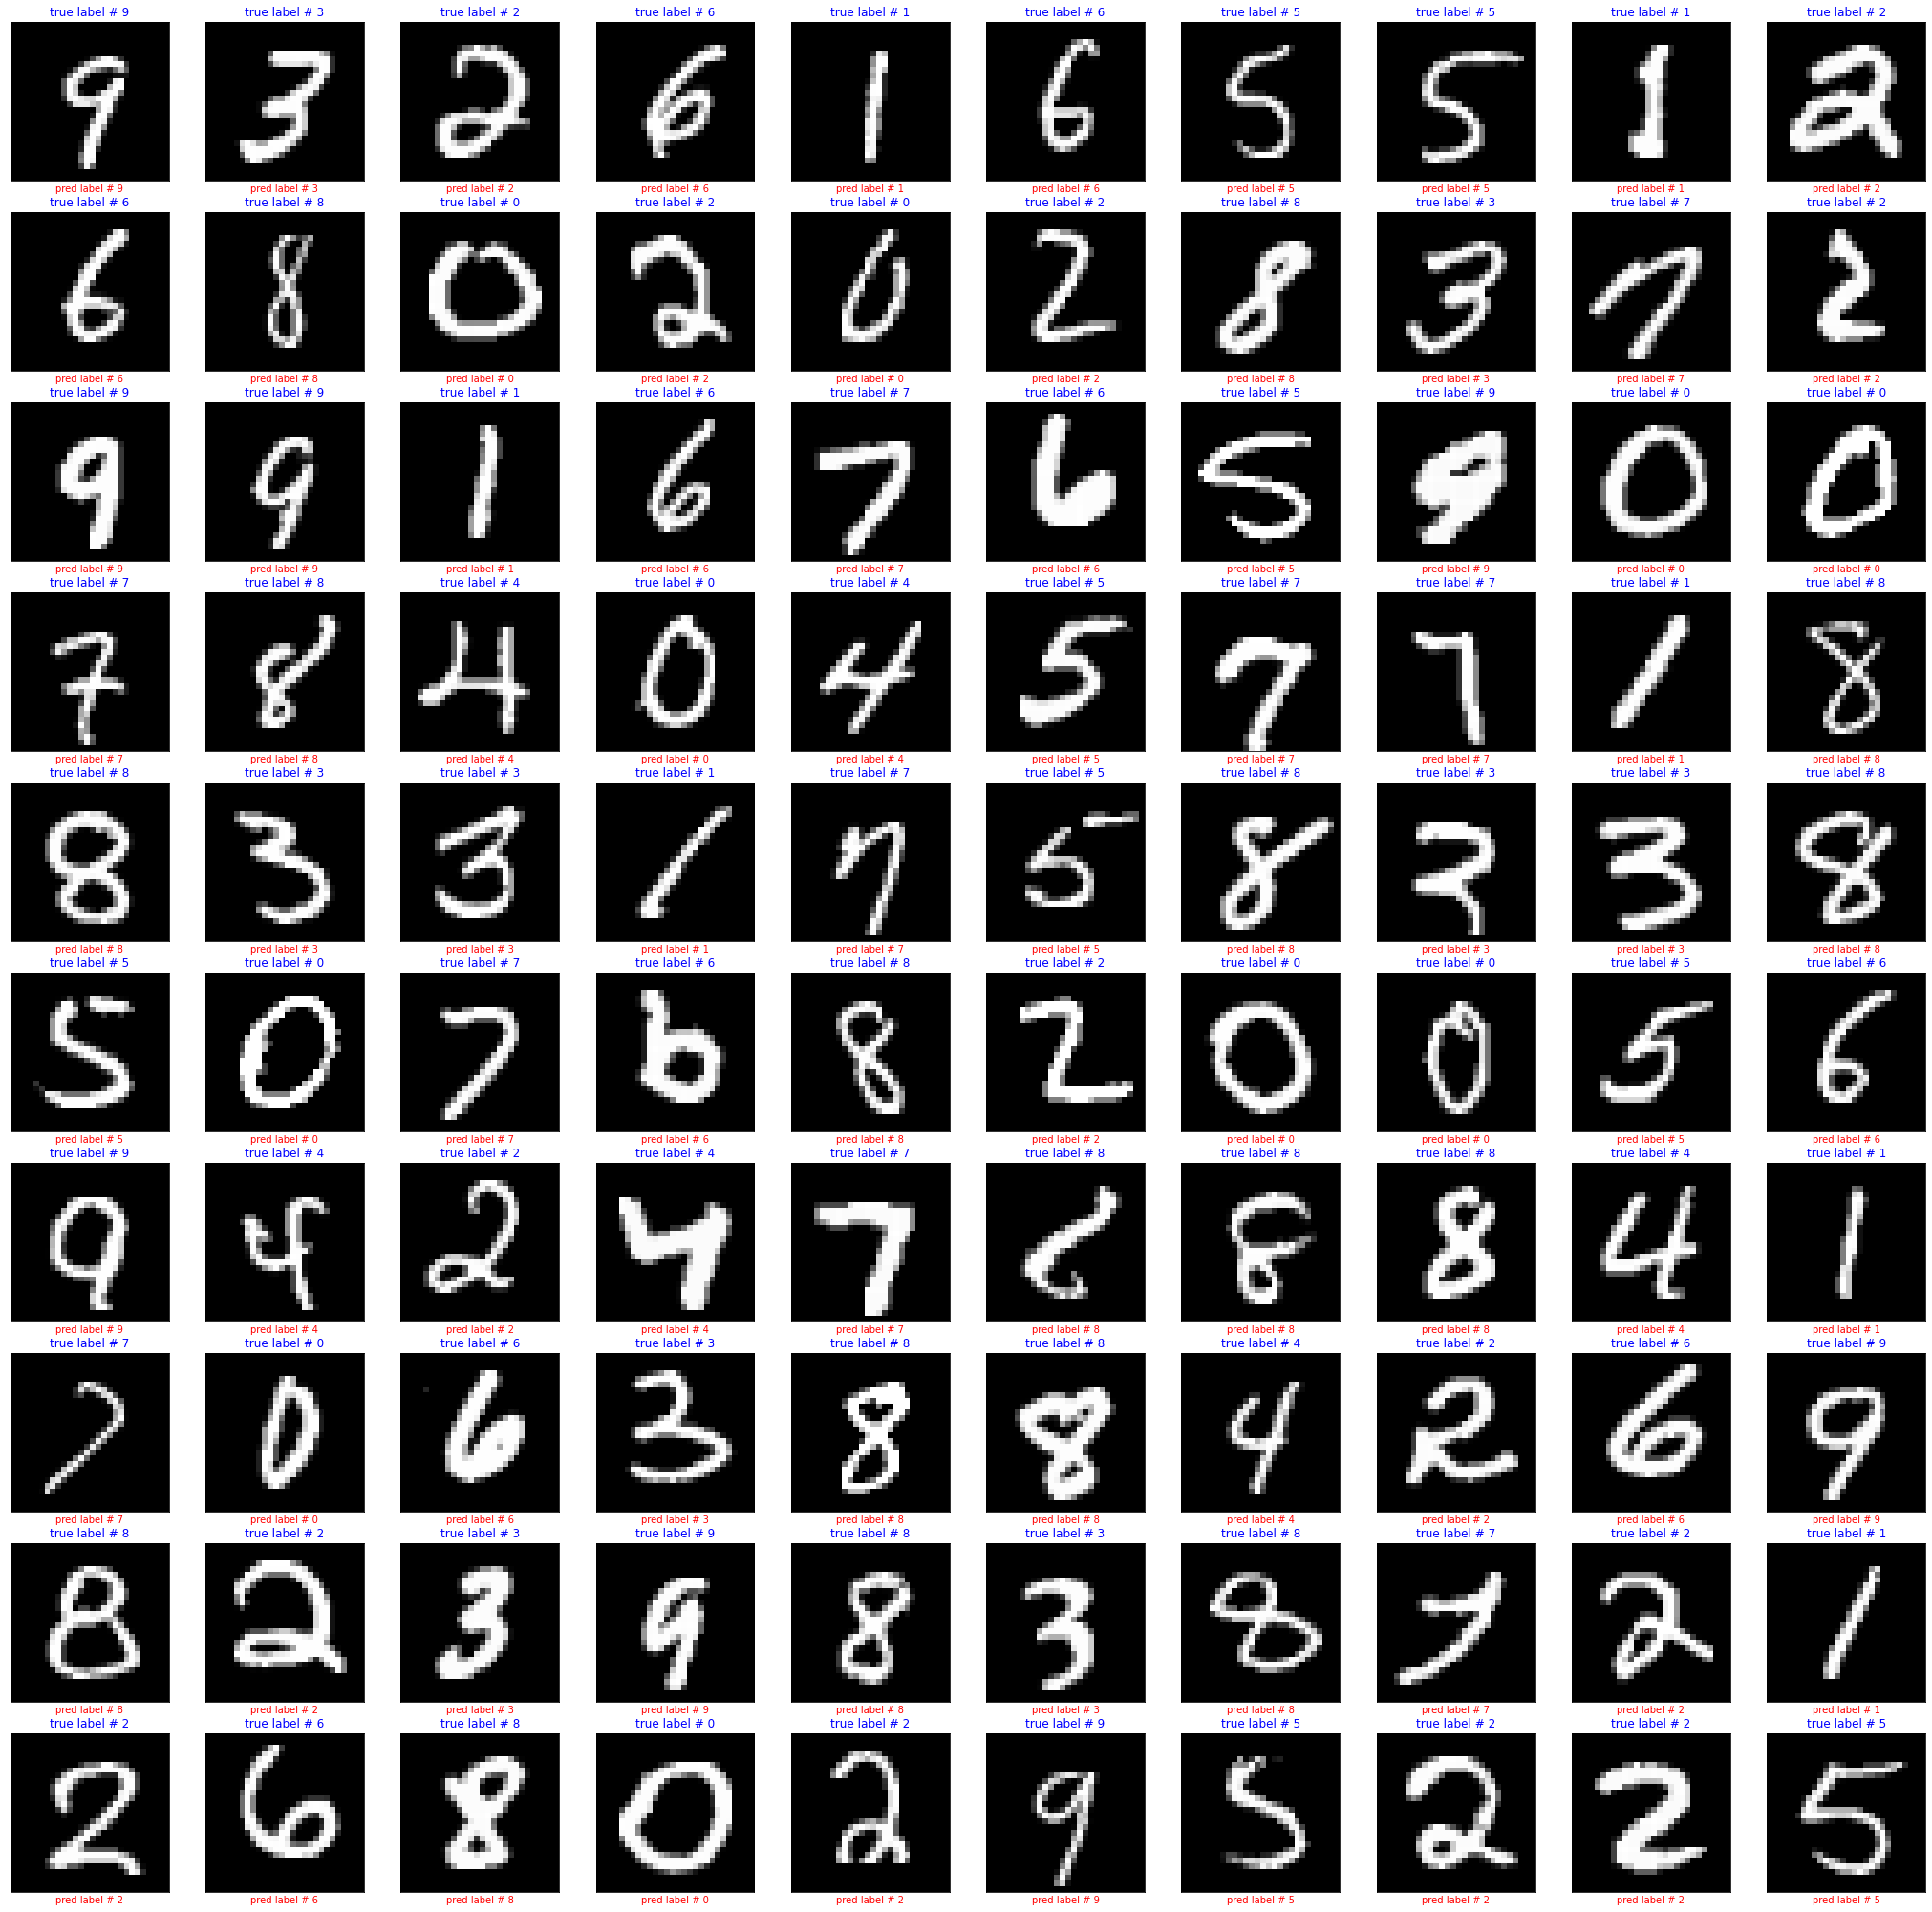

In [11]:
import matplotlib.pyplot as plt
test_iter=iter(test_loader)

GT_label,P_label,image=[],[],[]
for i in range(100):
    inputs,labels=test_iter.next()
    outputs=model(Variable(inputs))
    _,predicted=torch.max(outputs.data,1)
    GT_label.append(labels[0].numpy().astype(np.int32))
    P_label.append(predicted[0].numpy().astype(np.int32))
    image.append(inputs[0].numpy().reshape(28,28))
    
plt.figure(figsize=[36,36])
for e,(gt,p,i) in enumerate(zip(GT_label,P_label,image)):
    plt.subplot(10,10,e+1)
    plt.imshow(i,cmap='gray') #gray scaleで描画
    plt.xticks([]) #メモリいらない
    plt.yticks([])
    plt.title("true label # %01d" %gt,c='b') #blueでtrue labelをタイトルとして描画
    plt.xlabel("pred label # %01d" %p,c='r') #redでpred labetをx軸ラベルとして描画